<a href="https://colab.research.google.com/github/asjnhy/AI-courses-2019/blob/master/MNIST-SGD-SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [0]:
import os
import math
import time
import numpy as np
import matplotlib.pyplot as pyplot
from mlxtend.data import loadlocal_mnist
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Binary Classifier

In [0]:
class BinaryClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, batch_size=32, max_iter=100, learning_rate=0.1, random_state=1, C=100):
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.C = C
        self.rgen = np.random.RandomState(self.random_state)
        
    def fit(self, X, y):
        
        # 예외 처리
        if self.C < 0:
            raise ValueError("The C value of %r must be positive" % self.C)
        if ((self.learning_rate < 0) or (self.learning_rate > 1)):
            raise ValueError("The learning_rate value of %r is invalid. Set the learning_rate value between 0.0 and 1.0." % self.learning_rate)
            
        # 배치 개수 설정 : 데이터의 총 개수 / 배치 사이즈
        n_batches = math.ceil(len(X) / self.batch_size)
        n_rest = X.shape[0] - (n_batches-1) * self.batch_size # 80000 - (313-1)*256 = 128
        
        # w, b 값 초기화
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = 0.
        
        for epoch in range(self.max_iter):
            
            # 매 에포크마다 데이터 셔플
            X, y = self.shuffle(X, y)
            
            for j in range(n_batches - 1):
                # 입력한 배치 사이즈만큼 배치를 설정해준다. (defalut : 32 이므로 0~31, 32~63, ...)
                X_mini = X[j*self.batch_size : (j+1)*self.batch_size]
                y_mini = y[j*self.batch_size : (j+1)*self.batch_size]
                
                F_prime_w_i_sum = np.zeros(X.shape[1])
                F_prime_b_i_sum = 0.
                
                # 각 배치의 사이즈 만큼 (defalut : 32)
                for i in range(self.batch_size):
                    if ( y_mini[i] * self.hypothesis(X_mini[i]) < 1):
                        F_prime_w_i_sum += (-1)*y_mini[i]*X_mini[i]
                        F_prime_b_i_sum += (-1)*y_mini[i]

                # 가중치, 편향 업데이트
                self.w_ -= self.learning_rate * ((1 / self.batch_size) * F_prime_w_i_sum + (1/self.C)*self.w_)
                self.b_ -= self.learning_rate * ((1 / self.batch_size) * F_prime_b_i_sum)
            
            # 마지막 배치
            X_mini_rest = X[j*n_rest : (j+1)*n_rest]
            y_mini_rest = y[j*n_rest : (j+1)*n_rest]
            F_prime_w_i_sum = np.zeros(X.shape[1])
            F_prime_b_i_sum = 0.
            
            for i in range(n_rest):
                if ( y_mini_rest[i] * self.hypothesis(X_mini_rest[i]) < 1):
                    F_prime_w_i_sum += (-1)*y_mini_rest[i]*X_mini_rest[i]
                    F_prime_b_i_sum += (-1)*y_mini_rest[i]
                    
            self.w_ -= self.learning_rate * ((1 / n_rest) * F_prime_w_i_sum + (1/self.C)*self.w_)
            self.b_ -= self.learning_rate * ((1 / n_rest) * F_prime_b_i_sum)
            
        return self
    
    def predict(self, X):
        return np.where(self.hypothesis(X) >= 1, 1, -1)
    
    def hypothesis(self, X):
        return np.dot(X, self.w_) + self.b_
    
    def shuffle(self, X, y):
        shuffle_index = np.arange(X.shape[0])
        np.random.shuffle(shuffle_index)
        return X[shuffle_index], y[shuffle_index]
    
    # def score(self, X, y):
    #     return ClassifierMixin.score(X, y)

# Multiclass classifier

In [0]:
class MulticlassClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, batch_size=32, max_iter=100, learning_rate=0.1, random_state=1, C=100):
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.C = C
        
    def fit(self, X, y):
        self.labels = np.unique(y) # 0 ~ 9
        self.outputs_ = []
        for label in range(len(self.labels)):
            y_binary = np.where(y == label, 1, -1)
            b_c = BinaryClassifier(self.batch_size, self.max_iter, self.learning_rate, self.random_state, self.C)
            b_c.fit(X, y_binary)
            self.outputs_.append(b_c)
        return self
        
    def predict(self, X):
        prediction = []
        for o in self.outputs_:
            prediction.append(o.hypothesis(X))
        return self.labels[np.argmax(prediction, axis=0)]
    
    # def score(self, X, y):
    #     return ClassifierMixin.score(X, y)

# MNIST Training / Test Data Set Load

In [0]:
X_train, y_train = loadlocal_mnist(
                    images_path= os.getcwd()+'/drive/My Drive/9퍼따리/data/newtrain-images-idx3-ubyte', 
                    labels_path= os.getcwd()+'/drive/My Drive/9퍼따리/data/newtrain-labels-idx1-ubyte')
X_test, y_test = loadlocal_mnist(
                    images_path= os.getcwd()+'/drive/My Drive/9퍼따리/data/test-images-idx3-ubyte', 
                    labels_path= os.getcwd()+'/drive/My Drive/9퍼따리/data/test-labels-idx1-ubyte')

# Data Preprocessing (Scaled)

In [0]:
scaler = StandardScaler()
StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Data Preprocessing (PCA)

In [0]:

X_train_scaled = X_train_scaled.reshape(-1, 28*28)
pca = PCA(n_components=0.95)
X_train_scaled_reduced = pca.fit_transform(X_train_scaled) 
X_test_scaled_reduced = pca.transform(X_test_scaled)

# Training / Prediction

In [0]:
start = time.time()  # 시작 시간 저장

m=MulticlassClassifier(C=1000, learning_rate=0.01, batch_size=256)
m.fit(X_train_scaled_reduced, y_train)

y_pred = m.predict(X_test_scaled_reduced)
score = accuracy_score(y_test,y_pred)
print(score)
print("time :", time.time() - start)

0.831
time : 590.4655265808105


In [0]:
# start = time.time()  # 시작 시간 저장

# param_grid = {
#     'C' : [10,100], #100, 1000
#     'learning_rate' : [0.1], #0.001, 0.01
#     'batch_size' : [128], # 팀원당 할당된 batch_size 설정
# }

# grid_search = GridSearchCV(MulticlassClassifier(), 
#                            param_grid=param_grid, 
#                            cv=3,verbose=1, scoring='accuracy'
#                            ,n_jobs=-1)
# grid_search.fit(X_train_scaled_reduced, y_train)
# print("time :", time.time() - start)
# print(grid_search.best_params_)
# print(grid_search.best_score_)

In [0]:
# start = time.time()  # 시작 시간 저장

# m=MulticlassClassifier(C=1000, learning_rate=0.01, batch_size=128)
# m.fit(X_train, y_train)

# y_pred = m.predict(X_test)
# score = accuracy_score(y_test,y_pred)
# print(score)
# print("time :", time.time() - start)

0.7891
time : 597.9242887496948


#Visualization 

[[ 920    2    9   24    1   12   12    6   10    5]
 [   2 1008    5   15    2   17    6   24   46    2]
 [  15   13  812   36   24    5   35   20   21   10]
 [   5   12   31  870    3   34    4   22   22   29]
 [   4   17   11    7  832    3   18   10   17   61]
 [  14    7    9   74   13  657   34   15   25   15]
 [   6   33   16    3    4   26  907    1   12    6]
 [   7   11   23    9   23    2    4  939    8   44]
 [  22   40   26   75    5   44   28   17  645   42]
 [  11   10    5   39   52   11    2   81   47  720]]


Text(0.5, 0, 'Predicted Label')

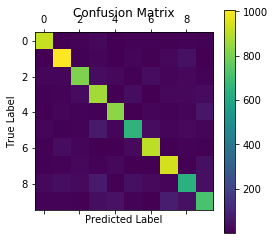

In [0]:
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt

confusion_matrix= confusion_matrix(y_test,y_pred)
print(confusion_matrix)
plt.matshow(confusion_matrix)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

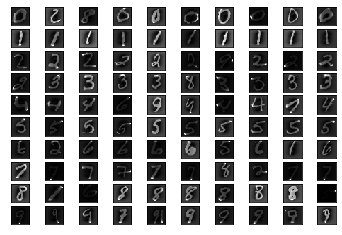

In [0]:
def viz_img(y_pred):
    n = 10
    fig = plt.figure(1)
    box_index = 1
    for img in range(n):
        result = np.where(y_pred == img)
        for i in np.random.choice(result[0].tolist(), n, replace=False):
            ax = fig.add_subplot(n, n, box_index)
            plt.imshow(X_test_scaled[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            box_index += 1
    plt.show()



viz_img(y_pred)

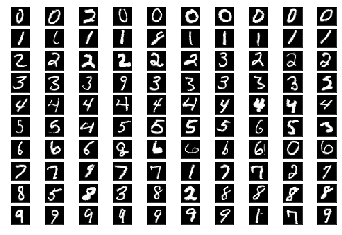

In [0]:
def viz_img(y_pred):
    n = 10
    fig = plt.figure(1)
    box_index = 1
    for img in range(n):
        result = np.where(y_pred == img)
        for i in np.random.choice(result[0].tolist(), n, replace=False):
            ax = fig.add_subplot(n, n, box_index)
            plt.imshow(X_test[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            box_index += 1
    plt.show()



viz_img(y_pred)

#PCA 차원 784 차원 -> 345차원으로 축소

In [0]:
pca.n_components_

In [0]:
sum(pca.explained_variance_ratio_)

0.950076264241583

In [0]:
sum(pca.explained_variance_) 

716.3664578188956

In [0]:
import matplotlib.pyplot as plt

pca = PCA()

pca.fit(X_train_scaled)

pca.n_components

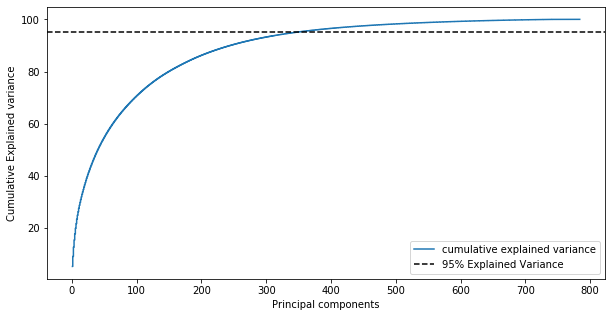

In [0]:
tot = sum(pca.explained_variance_)
var_exp = [(i/tot)*100 for i in sorted(pca.explained_variance_, reverse=True)] 
cum_var_exp = np.cumsum(var_exp)
plt.figure(figsize=(10, 5))
plt.step(range(1, 785), cum_var_exp, where='mid',label='cumulative explained variance')

plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
# plt.axhline(y = 90, color='c', linestyle='--', label = '90% Explained Variance')
# plt.axhline(y = 85, color='r', linestyle='--', label = '85% Explained Variance')
plt.legend(loc='best')
plt.show()

In [0]:
import matplotlib.pyplot as plt

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm


X_recovered = pca.inverse_transform(X_train_reduced)#PCA후 다시 압축 회복 


def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(28,28) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = cm.binary, **options)
    plt.axis("off")

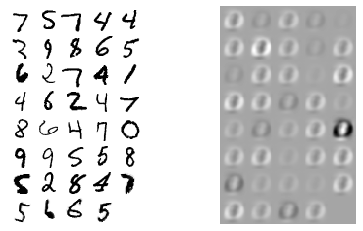

In [0]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
# plt.title("원본", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
# plt.title("압축 후 복원", fontsize=16)
plot_digits(X_recovered[::2100])

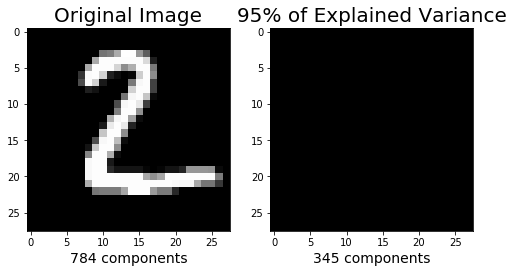

In [0]:
X_recovered 

plt.figure(figsize=(8,4));

plt.subplot(1,2,1)
plt.imshow(X_train[1].reshape(28,28),
           cmap = plt.cm.gray,
           clim = (0,255));
plt.xlabel('784 components', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 154 principal components
plt.subplot(1, 2, 2);
plt.imshow(X_recovered[4].reshape(28, 28),
              cmap = plt.cm.gray,#cm.binary? 
              clim=(0, 255));
plt.xlabel('345 components', fontsize = 14)
plt.title('95% of Explained Variance', fontsize = 20);


In [0]:
X_recovered[1].reshape(28,28)

##PCA without scaling 

In [0]:
# X_train_scaled
# X_train_scaled_reduced
# X_train_reduced 



X_train = X_train.reshape(-1, 28*28)
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train) 
X_test_reduced = pca.transform(X_test)

start = time.time()  # 시작 시간 저장

m=MulticlassClassifier(C=1000, learning_rate=0.01, batch_size=128)
m.fit(X_train_reduced, y_train)

y_pred_noSc = m.predict(X_test_reduced)
score_noSc = accuracy_score(y_test,y_pred_noSc)
print(score_noSc)
print("time :", time.time() - start)

0.5243
time : 693.6824533939362


In [0]:
import matplotlib.pyplot as plt

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm


X_recovered = pca.inverse_transform(X_train_reduced)


def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(28,28) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = cm.binary, **options)
    plt.axis("off")

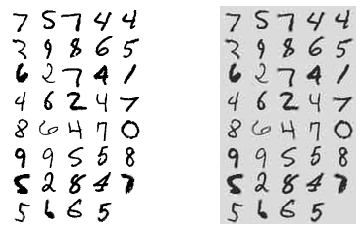

In [0]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
# plt.title("원본", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
# plt.title("압축 후 복원", fontsize=16)
plot_digits(X_recovered[::2100])

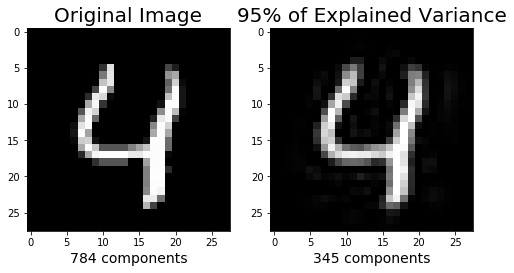

In [0]:
X_recovered 

plt.figure(figsize=(8,4));

plt.subplot(1,2,1)
plt.imshow(X_train[4].reshape(28,28),
           cmap = plt.cm.gray,
           clim = (0,255));
plt.xlabel('784 components', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 154 principal components
plt.subplot(1, 2, 2);
plt.imshow(X_recovered[4].reshape(28, 28),
              cmap = plt.cm.gray,#cm.binary? 
              clim=(0, 255));
plt.xlabel('345 components', fontsize = 14)
plt.title('95% of Explained Variance', fontsize = 20);


In [0]:
pca.n_components_

154

In [0]:
sum(pca.explained_variance_ratio_)

0.950141070240831

In [0]:
sum(pca.explained_variance_)

3253217.2287235875

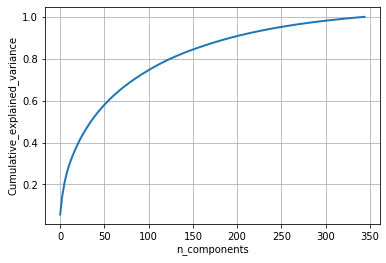

In [0]:
import matplotlib.pyplot as plt
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)

plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()